In [1]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.0 MB/s eta 0:00:00


# Downloading data

In [2]:
import pandas as pd
import requests
import patoolib
from pathlib import Path
import os

In [3]:
os.makedirs('data')
dest_path = os.path.join(os.getcwd(),'data')

In [4]:
URL = "https://raw.githubusercontent.com/rodrigosantis1/backorder_prediction/master/dataset.rar"
response = requests.get(URL)
open("data/dataset.rar", "wb").write(response.content)


24741696

In [5]:
patoolib.extract_archive(dest_path+'/dataset.rar', outdir=dest_path)

patool: Extracting /content/data/dataset.rar ...
patool: running /usr/bin/unrar x -- /content/data/dataset.rar
patool:     with cwd='/content/data'
patool: ... /content/data/dataset.rar extracted to `/content/data'.


'/content/data'

# Preparing Data

In [6]:
df1 = pd.read_csv(dest_path+'/Kaggle_Training_Dataset_v2.csv')
df2 = pd.read_csv(dest_path+'/Kaggle_Test_Dataset_v2.csv')

<ipython-input-6-d3d6d640aed0>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(dest_path+'/Kaggle_Training_Dataset_v2.csv')
<ipython-input-6-d3d6d640aed0>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(dest_path+'/Kaggle_Test_Dataset_v2.csv')


In [7]:
df3 = pd.concat([df1,df2])

In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929937 entries, 0 to 242075
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sku                object 
 1   national_inv       float64
 2   lead_time          float64
 3   in_transit_qty     float64
 4   forecast_3_month   float64
 5   forecast_6_month   float64
 6   forecast_9_month   float64
 7   sales_1_month      float64
 8   sales_3_month      float64
 9   sales_6_month      float64
 10  sales_9_month      float64
 11  min_bank           float64
 12  potential_issue    object 
 13  pieces_past_due    float64
 14  perf_6_month_avg   float64
 15  perf_12_month_avg  float64
 16  local_bo_qty       float64
 17  deck_risk          object 
 18  oe_constraint      object 
 19  ppap_risk          object 
 20  stop_auto_buy      object 
 21  rev_stop           object 
 22  went_on_backorder  object 
dtypes: float64(15), object(8)
memory usage: 353.4+ MB


In [9]:
df3.drop(columns='sku',inplace=True)
df3.shape

(1929937, 22)

In [10]:
# fetching numeric and categoric features in different lists
numeric_features = []
categorical_features = []
for i in df3.columns:
  if df3[i].dtype == 'O':
    categorical_features.append(i)
  else:
    numeric_features.append(i)

print('numeric_features: ',numeric_features)
print('categorial_features: ', categorical_features)

numeric_features:  ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']
categorial_features:  ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


### Imputation

In [11]:
df3.isna().sum()

national_inv              2
lead_time            115619
in_transit_qty            2
forecast_3_month          2
forecast_6_month          2
forecast_9_month          2
sales_1_month             2
sales_3_month             2
sales_6_month             2
sales_9_month             2
min_bank                  2
potential_issue           2
pieces_past_due           2
perf_6_month_avg          2
perf_12_month_avg         2
local_bo_qty              2
deck_risk                 2
oe_constraint             2
ppap_risk                 2
stop_auto_buy             2
rev_stop                  2
went_on_backorder         2
dtype: int64

In [12]:
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy='mean')
df3['lead_time'] = impute.fit_transform(df3[['lead_time']])

In [13]:
df3.dropna(inplace=True)

### Converting categorical to Numerical

In [14]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(df3[categorical_features])
df3[categorical_features] = enc.transform(df3[categorical_features])

### Handling imbalance data

In [15]:
df3['went_on_backorder'].value_counts()

0.0    1915954
1.0      13981
Name: went_on_backorder, dtype: int64

In [16]:
from sklearn.utils import resample

df_majority = df3[(df3['went_on_backorder']==0)]
df_minority = df3[(df3['went_on_backorder']==1)]

# downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=True,    # sample with replacement
                                 n_samples= df3['went_on_backorder'].value_counts().min(), # to match majority class
                                 random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [17]:
df_downsampled['went_on_backorder'].value_counts()

0.0    13981
1.0    13981
Name: went_on_backorder, dtype: int64

### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_downsampled.iloc[:,:-1], df_downsampled.iloc[:,-1], test_size=0.2, random_state=41)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22369, 21), (5593, 21), (22369,), (5593,))

### Scaling the Data

In [19]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [20]:
X_train[0]

array([-0.11202732,  0.16064091, -0.0731738 , -0.05509312, -0.05946751,
       -0.05707092, -0.11593292, -0.13508416, -0.13725057, -0.13014371,
       -0.10072563, -0.05186037, -0.0551113 ,  0.25286037,  0.24648095,
       -0.04340036, -0.48979384, -0.0189147 , -0.39393512,  0.20188476,
       -0.0189147 ])

In [21]:
X_test[0]

array([-0.09956829, -0.56022603, -0.0731738 , -0.05509312, -0.05946751,
       -0.05707092, -0.11593292, -0.13508416, -0.13725057, -0.12920678,
       -0.10072563, -0.05186037, -0.0551113 ,  0.24902054,  0.24385121,
       -0.04340036, -0.48979384, -0.0189147 , -0.39393512,  0.20188476,
       -0.0189147 ])

In [22]:
y_train[:10]

132631     0.0
333026     1.0
7543       1.0
238005     1.0
398569     0.0
147234     1.0
1117857    1.0
1280969    0.0
25044      0.0
1375026    1.0
Name: went_on_backorder, dtype: float64

In [23]:
y_test[:10]

90260      0.0
1224458    1.0
134625     1.0
205904     0.0
133777     1.0
299877     0.0
1265995    0.0
1157479    0.0
93095      1.0
386357     0.0
Name: went_on_backorder, dtype: float64

### Training using Logistic Regression and predicting

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
Lr = LogisticRegression()

In [26]:
Lr.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
y_pred = Lr.predict(X_test)

### Evaluation

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.54      0.78      0.64      1959
         1.0       0.85      0.63      0.72      3634

    accuracy                           0.69      5593
   macro avg       0.69      0.71      0.68      5593
weighted avg       0.74      0.69      0.69      5593



# Using deeplearning using Tensorflow and Keras

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

In [30]:
# Define i/p and o/p shapes of tensors
input_dims = X_train.shape[1]
output_dims = 2

In [60]:
# Defining Sequential model
model = Sequential()

# Add i/p layer to the sequential model
model.add(tf.keras.Input(shape = (input_dims,), name = 'inputLayer'))

# Add first dense layer to the sequential model
model.add(Dense(60, activation='relu', name='HLayer1'))
model.add(tf.keras.layers.Dropout(0.2))

# Add Second dense layer to the model
model.add(Dense(30, activation='relu', name='HLayer2'))
model.add(tf.keras.layers.Dropout(0.2))


# Add Second dense layer to the model
model.add(Dense(15, activation='relu', name='HLayer3'))
model.add(tf.keras.layers.Dropout(0.2))


# Add output layer
model.add(Dense(1, activation='sigmoid', name='outputlayer'))


In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HLayer1 (Dense)             (None, 60)                1320      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 HLayer2 (Dense)             (None, 30)                1830      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 HLayer3 (Dense)             (None, 15)                465       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 outputlayer (Dense)         (None, 1)                

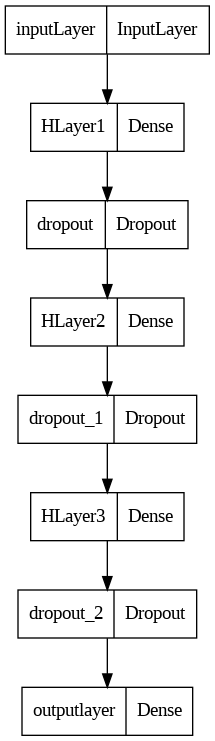

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [63]:
from tensorflow.keras.optimizers import Adam

# Defining optimizer
optimizer = Adam(0.001)

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [91]:
callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(dest_path,'best_model.h5'),
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq ='epoch',
    options=None,
    initial_value_threshold=None,
)

In [101]:
# Training the neural network

batch_size = 10
num_epoch = 100

#fit newural network
binary_clf = model.fit(X_train, y_train,
                       validation_split=0.2,
                       epochs=num_epoch,
                       batch_size = batch_size,
                       callbacks = [callback],
                       verbose=1  )

Epoch 1/100
1790/1790 [==============================] - 4s 2ms/step - loss: 0.3662 - accuracy: 0.8452 - val_loss: 0.3604 - val_accuracy: 0.8518
Epoch 2/100
1790/1790 [==============================] - 6s 3ms/step - loss: 0.3600 - accuracy: 0.8489 - val_loss: 0.4011 - val_accuracy: 0.8131
Epoch 3/100
1790/1790 [==============================] - 4s 2ms/step - loss: 0.3645 - accuracy: 0.8490 - val_loss: 0.3496 - val_accuracy: 0.8641
Epoch 4/100
1790/1790 [==============================] - 4s 2ms/step - loss: 0.3645 - accuracy: 0.8459 - val_loss: 0.3533 - val_accuracy: 0.8494
Epoch 5/100
1790/1790 [==============================] - 5s 3ms/step - loss: 0.3606 - accuracy: 0.8453 - val_loss: 0.3492 - val_accuracy: 0.8536
Epoch 6/100
1790/1790 [==============================] - 4s 2ms/step - loss: 0.3578 - accuracy: 0.8482 - val_loss: 0.3457 - val_accuracy: 0.8619
Epoch 7/100
1790/1790 [==============================] - 5s 3ms/step - loss: 0.3619 - accuracy: 0.8490 - val_loss: 0.3430 - val_ac

In [102]:
loaded_model = new_model = tf.keras.models.load_model(dest_path+'/best_model.h5')

In [103]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HLayer1 (Dense)             (None, 60)                1320      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 HLayer2 (Dense)             (None, 30)                1830      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 HLayer3 (Dense)             (None, 15)                465       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 outputlayer (Dense)         (None, 1)                

In [104]:
loaded_model.evaluate(X_test,y_test)

175/175 [==============================] - 0s 2ms/step - loss: 0.3499 - accuracy: 0.8630


[0.34989625215530396, 0.8630430698394775]

In [105]:
y_pred_nn = loaded_model.predict(X_test)

175/175 [==============================] - 0s 1ms/step


In [106]:
import numpy as np
y_pred_nn = np.round(y_pred_nn.squeeze())

In [107]:
pd.DataFrame(y_pred_nn[:10], y_test[:10])

,0
went_on_backorder,
0.0,0.0
1.0,1.0
1.0,0.0
0.0,0.0
1.0,1.0
0.0,0.0
0.0,0.0
0.0,0.0
1.0,1.0


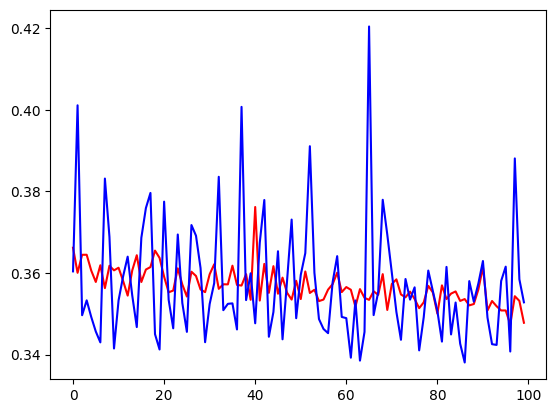

In [108]:
import matplotlib.pyplot as plt

plt.plot(binary_clf.history['loss'],color='red',label='train')
plt.plot(binary_clf.history['val_loss'],color='blue',label='validation')

In [109]:
print(classification_report(y_pred_nn, y_test))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      2765
         1.0       0.88      0.85      0.86      2828

    accuracy                           0.86      5593
   macro avg       0.86      0.86      0.86      5593
weighted avg       0.86      0.86      0.86      5593

